### Download data

In [1]:
from download_files import download

download()

../data/all_rain_future_4p5_DJF_sums_75km.nc exists
../data/all_rain_future_4p5_JJA_sums_75km.nc exists
../data/all_rain_future_4p5_MAM_sums_75km.nc exists
../data/all_rain_future_4p5_SON_sums_75km.nc exists
../data/all_rain_future_4p5_years_sums_75km.nc exists
../data/all_rain_future_8p5_DJF_sums_75km.nc exists
../data/all_rain_future_8p5_JJA_sums_75km.nc exists
../data/all_rain_future_8p5_MAM_sums_75km.nc exists
../data/all_rain_future_8p5_SON_sums_75km.nc exists
../data/all_rain_future_8p5_years_sums_75km.nc exists
../data/all_rain_historical_DJF_sums_75km.nc exists
../data/all_rain_historical_JJA_sums_75km.nc exists
../data/all_rain_historical_MAM_sums_75km.nc exists
../data/all_rain_historical_SON_sums_75km.nc exists
../data/all_rain_historical_years_sums_75km.nc exists
../data/mcs_rain_future_4p5_DJF_sums_75km.nc exists
../data/mcs_rain_future_4p5_JJA_sums_75km.nc exists
../data/mcs_rain_future_4p5_MAM_sums_75km.nc exists
../data/mcs_rain_future_4p5_SON_sums_75km.nc exists
../dat

# Code and examples in support of the boxplots in npj C&AS paper

### Define the regions used to select data subsets

In [2]:
regions = {'SP': ['TX', 'OK', 'KS'],
           'NP': ['NE', 'SD', 'ND'],
           'MW': ['WI', 'MI', 'OH', 'IL', 'IN', 'MN', 'IA', 'MO', 'KY'],
           'SE': ['AR', 'LA', 'TN', 'MS', 'AL', 'SC', 'NC', 'FL', 'GA'],
           'NE': ['NJ', 'PA', 'NY', 'VT', 'NH', 'CT', 'VA', 'WV', 'MD', 'DC', 'DE', 'RI', 'MA', 'ME'],
           'EC': []}

#ECONUS is comprised of states in all other regions
[regions['EC'].extend(regions[x]) for x in regions.keys() if x!='EC'];

region_names = {'EC': 'ECONUS', 
                'NP': 'Northern Plains', 
                'SP': 'Southern Plains', 
                'MW': 'Midwest', 
                'SE': 'Southeast', 
                'NE': 'Northeast'}

### Define function that uses regionmask and the CONUS shapefile to subset the data by region

In [3]:
import geopandas as gpd
import regionmask
import numpy as np

def mask_data(input_dataset, states, lon_name='lon', lat_name='lat', conus_shapefile_path='../data/CONUS.shp'):
    r"""Masks an input xarray dataset using the
    two character state IDs in states based on the 
    lon_name and lat_name coordinates in input_dataset and
    if they are within the given list of states. Original dataset 
    is not modified.
    
    Parameters
    ----------
    input_dataset: xarray dataset
        Dataset that you want to mask. Must have a lon and lat coordinate.
    states: list or ndarray
        List of states used to extract data subset.      
    lon_name: str
        Name of longitude coordinate in input_dataset. Default is 'lon'.
    lat_name: str
        Name of latitude coordinate in input_dataset. Default is 'lat'.
    conus_shapefile_path: str
        Path to shapefile used to extract geography information.
        
    Returns
    -------
    output_dataset: xarray dataset
        Modified input_dataset where grids not in states are set to nan.
    """
    
    usa = gpd.read_file(conus_shapefile_path)
    usa = usa[usa.STUSPS.isin(states)]

    state_mask = regionmask.mask_geopandas(usa, input_dataset[lon_name], input_dataset[lat_name])
    
    ma = state_mask.values
    ma[~np.isnan(ma)] = 1
    output_dataset = input_dataset * ma
    
    return output_dataset

# Demonstrate mask_data

#### Selection of states

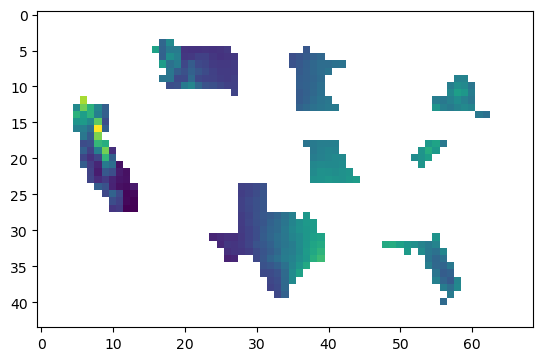

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import xarray as xr

ds = xr.open_dataset(f"../data/all_rain_historical_years_sums_75km.nc").mean('time')

ds_mask = mask_data(ds, states=['TX', 'MN', 'NY', 'CA', 'FL', 'MT',  'MO', 'WV'])

plt.imshow(np.flipud(ds_mask['mcs_mask']))

### Defined regions

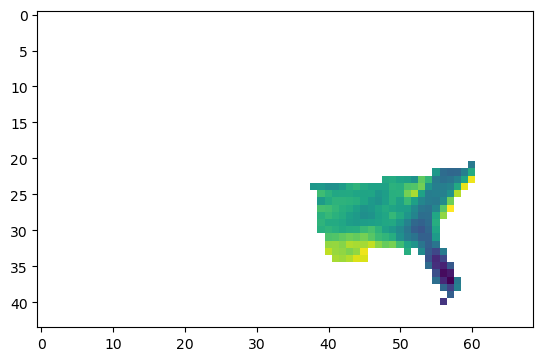

In [5]:
ds_mask = mask_data(ds, states=regions['SE'])

plt.imshow(np.flipud(ds_mask['mcs_mask']))

# Create a masked version of the original data

In [6]:
masked_data = {}

for event_type in ['all_rain', 'mcs_rain', 'non_mcs_rain']:
    
    masked_data[event_type] = {}
    
    for simulation in ['historical', 'future_4p5', 'future_8p5']:
        
        masked_data[event_type][simulation] = {}
        
        ds_event = xr.open_dataset(f"../data/{event_type}_{simulation}_years_sums_75km.nc")
        
        for region_id, region_states in regions.items():
            
            masked_data[event_type][simulation][region_id] = {}
            
            masked_ds = mask_data(ds_event, states=region_states)
        
            masked_data[event_type][simulation][region_id]['years_sums'] = masked_ds
            masked_data[event_type][simulation][region_id]['annual_mean'] = masked_ds.mean('time')

### Create ratios of MCS to ALL precipitation

In [7]:
masked_data['ratio'] = {}

for simulation in ['historical', 'future_4p5', 'future_8p5']:
    
    masked_data['ratio'][simulation] = {}

    for region_id, region_states in regions.items():

        masked_data['ratio'][simulation][region_id] = {}
        
        mcs_years = masked_data['mcs_rain'][simulation][region_id]['years_sums']
        all_years = masked_data['all_rain'][simulation][region_id]['years_sums']
        
        years_ratio =  mcs_years / all_years
        
        mcs_means = masked_data['mcs_rain'][simulation][region_id]['annual_mean']
        all_means = masked_data['all_rain'][simulation][region_id]['annual_mean']
        
        means_ratio =  mcs_means / all_means

        masked_data['ratio'][simulation][region_id]['years_sums'] = years_ratio
        masked_data['ratio'][simulation][region_id]['annual_mean'] = means_ratio

### Set the figure customizations

In [8]:
#Set figure size and some fontsizes
plt.rcParams['figure.figsize'] = 20, 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

#for panel labeling
import string
letters = string.ascii_lowercase
label_props = dict(boxstyle='round', facecolor='w', alpha=1)

#modify the default boxplot
meanpointprops = dict(marker='.', markeredgecolor='black',
                      markerfacecolor='black')

#What color to give each box
simulation_color_codes = {'historical': '#c7e9c0', 
                          'future_4p5': '#6baed6', 
                          'future_8p5': '#a50f15'}

#Custom legend markers
import matplotlib.lines as mlines

rc45_mark = mlines.Line2D([], [], color='k', marker='^', linestyle='None',
                          markersize=10)

rc85_mark = mlines.Line2D([], [], color='k', marker='s', linestyle='None',
                          markersize=10)

#Panel titles
titles = {'all_rain': "Mean Annual Precipitation\nAll",
          'mcs_rain': "Mean Annual Precipitation\nMCS",
          'non_mcs_rain': "Mean Annual Precipitation\nNon-MCS ",
          'ratio': "Mean Annual Precipitation\nRatio of MCS to All"}

#Axes range customization
limits = {'all_rain': {'ylow': 0, 'yhigh': 1600, 'units': 'mm'},
          'mcs_rain': {'ylow': 0, 'yhigh': 1200, 'units': 'mm'},
          'non_mcs_rain': {'ylow': 0, 'yhigh': 1200, 'units': 'mm'},
          'ratio': {'ylow': 0, 'yhigh': 0.7, 'units': 'mm mm$^{-1}$'}}

#Since dicts are not ordered
region_position = {'EC': 0, 'NP': 1, 'SP': 2, 'MW': 3, 'SE': 4, 'NE': 5}

# Generate boxplot figure

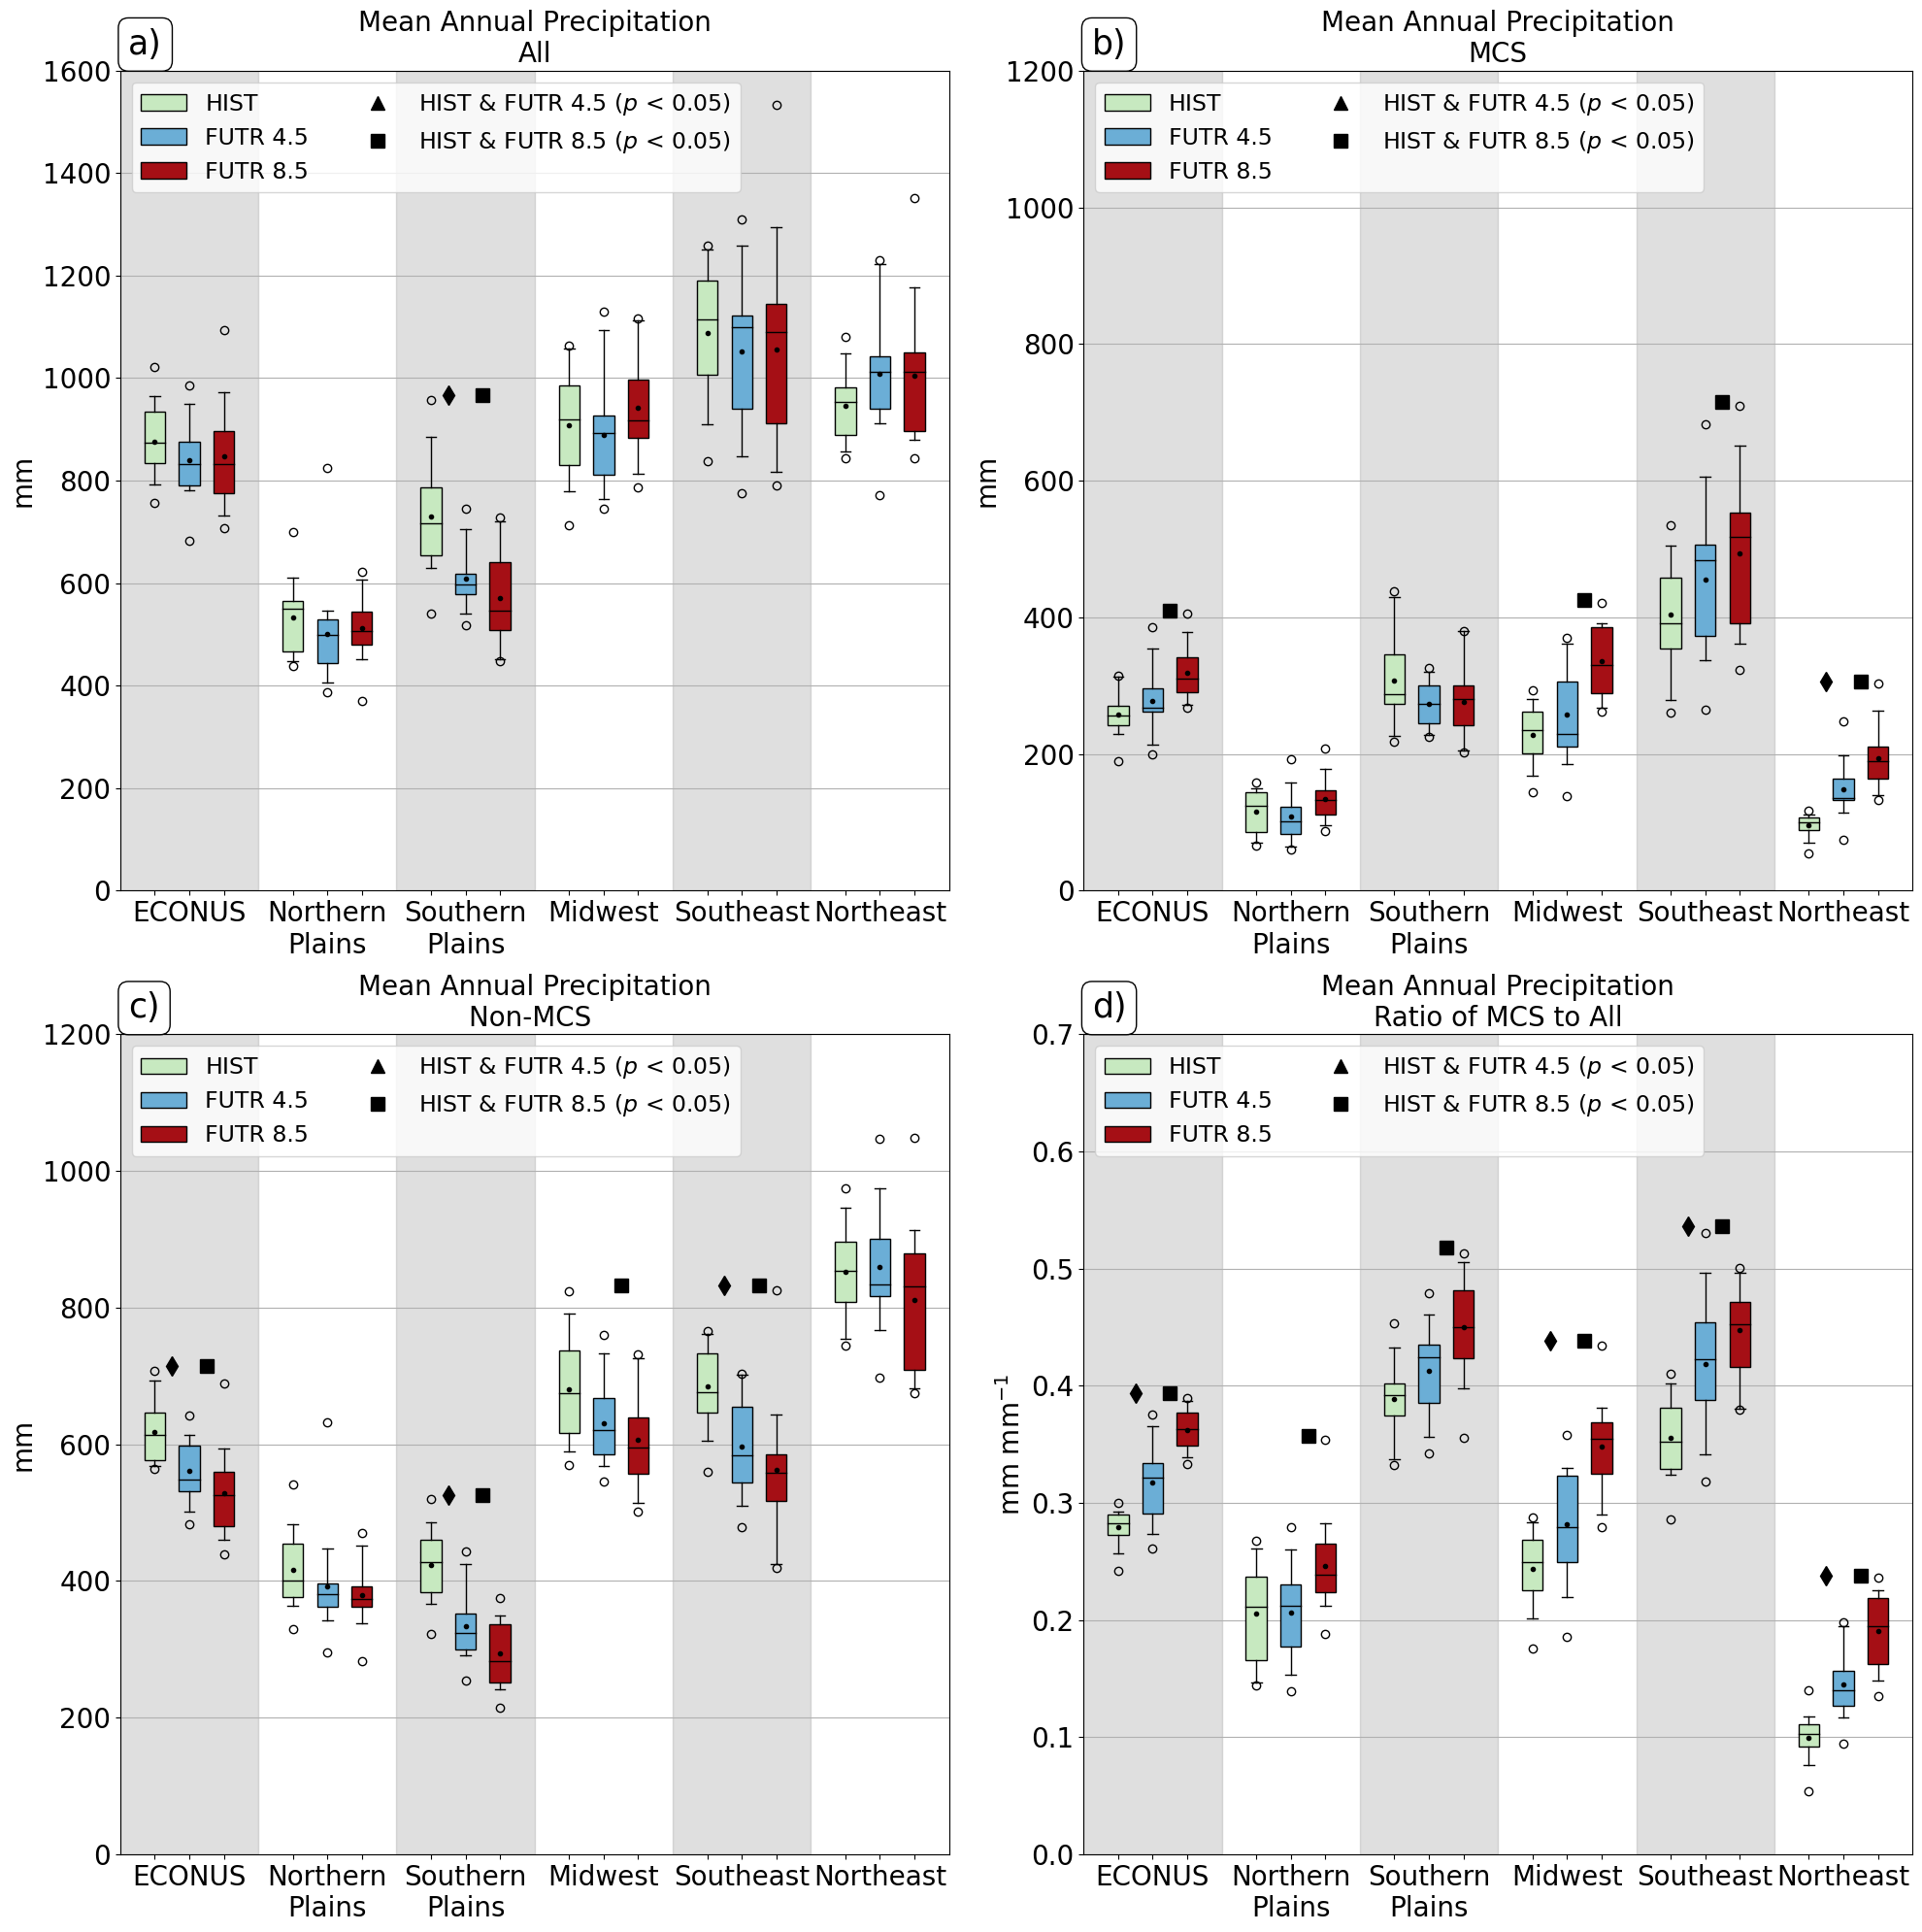

In [9]:
from scipy.stats import mannwhitneyu, pearsonr

for figure_position, (event_type, title) in enumerate(titles.items()):
    
    ax = plt.subplot(2, 2, figure_position + 1)
    
    ax.annotate(f"{letters[figure_position]})", (0.01,1.02), xycoords='axes fraction',
                   fontsize=25, bbox=label_props, color='k', zorder=25)
        
    ax.set_title(title)
    
    ax.set_xlim(-0.5, 5.5)
    ax.set_ylim(limits[event_type]['ylow'], limits[event_type]['yhigh'])
    ax.set_ylabel(limits[event_type]['units'])
    
    ax.axvspan(-0.5, 0.5, color='grey', alpha=0.25)
    ax.axvspan(1.5, 2.5, color='grey', alpha=0.25)
    ax.axvspan(3.5, 4.5, color='grey', alpha=0.25)
    
    ax.grid(axis='y')
    
    for region_id in regions.keys():
        
        hist = masked_data[event_type]['historical'][region_id]['years_sums']
        rcp45 = masked_data[event_type]['future_4p5'][region_id]['years_sums']
        rcp85 = masked_data[event_type]['future_8p5'][region_id]['years_sums']
        
        hist = hist.mean(('west_east', 'south_north'))['mcs_mask'].values
        rcp45 = rcp45.mean(('west_east', 'south_north'))['mcs_mask'].values
        rcp85 = rcp85.mean(('west_east', 'south_north'))['mcs_mask'].values
        
        rpos = region_position[region_id]
        
        bplot = ax.boxplot([hist, rcp45, rcp85], 
                           positions=[rpos - .25, rpos, rpos + 0.25], 
                           patch_artist=True, labels=['', region_names[region_id].replace(" ", "\n"), ''],
                           whis=[5, 95], showmeans=True, meanprops=meanpointprops)
        
        plt.setp(bplot['medians'], color='black')
        [item.set_color('black') for item in bplot['means']] 

        for sim, patch in zip(['historical', 'future_4p5', 'future_8p5'], bplot['boxes']):
            patch.set_facecolor(simulation_color_codes[sim])
            
        _, ph45 = mannwhitneyu(hist, rcp45)
        _, ph85 = mannwhitneyu(hist, rcp85)

        if ph45 < 0.05:
            m45 = ax.plot(rpos-0.125, 1.01*np.max([hist, rcp45, rcp85]), "kd", ms=10)

        if ph85 < 0.05:
            m85 = ax.plot(rpos+0.125, 1.01*np.max([hist, rcp45, rcp85]), "ks", ms=10)
    
    ax.legend([bplot["boxes"][0], bplot["boxes"][1], bplot["boxes"][2], rc45_mark, rc85_mark],
              ['HIST', 'FUTR 4.5', 'FUTR 8.5', 
               r'HIST & FUTR 4.5 ($\mathit{p}$ < 0.05)', r'HIST & FUTR 8.5 ($\mathit{p}$ < 0.05)'], 
              loc='upper left', prop={'size':17}, ncol=2)    
    
plt.tight_layout()

plt.savefig("Figure2_revised.png", dpi=200, bbox_inches='tight')

# Calculate pearson r for the spatial correlation between annual MCS and NON-MCS precipitation and ALL in HIST

In [10]:
for region_id in regions.keys():
        
    hist_all = masked_data['all_rain']['historical'][region_id]['annual_mean']['mcs_mask'].values.flatten()
    hist_mcs = masked_data['mcs_rain']['historical'][region_id]['annual_mean']['mcs_mask'].values.flatten()
    hist_non_mcs = masked_data['non_mcs_rain']['historical'][region_id]['annual_mean']['mcs_mask'].values.flatten()
    
    hist_all = hist_all[~np.isnan(hist_all)]
    hist_mcs = hist_mcs[~np.isnan(hist_mcs)]
    hist_non_mcs = hist_non_mcs[~np.isnan(hist_non_mcs)]
    
    all_mcs_r, all_mcs_p = pearsonr(hist_all, hist_mcs)
    all_non_r, all_non_p = pearsonr(hist_all, hist_non_mcs)
    
    print(region_names[region_id], "ALL and MCS", f"r={all_mcs_r:.2f}", f"p={all_mcs_p:.2f}")
    print(region_names[region_id], "ALL and NON-MCS", f"r={all_non_r:.2f}", f"p={all_non_p:.2f}")
    print("")

Southern Plains ALL and MCS r=0.99 p=0.00
Southern Plains ALL and NON-MCS r=0.97 p=0.00

Northern Plains ALL and MCS r=0.93 p=0.00
Northern Plains ALL and NON-MCS r=0.83 p=0.00

Midwest ALL and MCS r=0.62 p=0.00
Midwest ALL and NON-MCS r=0.75 p=0.00

Southeast ALL and MCS r=0.75 p=0.00
Southeast ALL and NON-MCS r=0.43 p=0.00

Northeast ALL and MCS r=0.40 p=0.00
Northeast ALL and NON-MCS r=0.91 p=0.00

ECONUS ALL and MCS r=0.66 p=0.00
ECONUS ALL and NON-MCS r=0.75 p=0.00

